# Описание проекта

Имеется интернет-магазин "Стримчик", который продаёт по всему миру компьютерные игры. Предоставлены данные до 2016 года о продажах игр, оценках пользователей и критиков, жанры и платформы.

**Цель прокета**

- Выявить закономерности определяющие успешность игры
- Сделать проноз на 2017 год, чтобы спланировать рекламную компанию

# План

1. Сделать обзор данных
1. Сделать предобработку данных
2. Провести статистический анализ
3. Построить портреты пользователей по регионам
4. Проверить несколько гипотез
5. Написать вывод с рекомендациями

## Общая информация

Импортируем нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import missingno as msno

Откроем файл

In [2]:
try:
    df = pd.read_csv('C:/Users/99893/yandex_practicum_course/module_1 Сборный проект\games.csv')
except:
    df = pd.read_csv('/datasets/games.csv.')

Выведем первые 5 строк

In [3]:
df.head()

Общая информация по загруженному датафрейму

In [4]:
df.info()

In [5]:
df.shape[0]

**Вывод:**

- Строк в датафрейме 16715
- Признаков 11

Имеются пропуски в некоторых столбцах, названия столбцов записаны не практично с точки зрения работы с датафреймом

## Предобработка данных

### Переименование столбцов датафрейма

In [6]:
def formatting_col(name_col):
    return name_col.lower().replace(' ', '_')

In [7]:
df.rename(columns=formatting_col, inplace=True)
df.head(3)

### Измение типа данных

Создадим функцию, которая будет менять тип данных

In [8]:
# Функция изменяющая тип данных для столбцов датафрейма
def changing_type (data, column, data_type):
    try:
        data[column] = data[column].astype(data_type)
        print('Изменение прошло успешно')
    
    except ValueError as e:
        print(f'''{type(e)}
В столбце "{column}" имеются значения, которые не конвертируются в тип данных "{data_type}"''')

    except KeyError as e:
        print(f'''{type(e)}
В датафрейме нет столбца "{column}"
Проверьте название столбца!''')
    
    except TypeError as e:
        print(f'''{type(e)}
Введен неправильный тип данных: {data_type}
Проверьте правильность ввода типа данных, в который хотите конвертировать столбец''')

In [9]:
changing_type(df, 'year_of_release', 'int64')

In [10]:
changing_type(df, 'user_score', 'float64')

In [11]:
df['user_score'].unique()

In [12]:
df.loc[df['user_score'] == 'tbd', 'user_score'].count()

In [13]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = np.nan

In [14]:
changing_type(df, 'user_score', 'float64')

### Обработка пропусков

In [15]:
def pass_value_barh(data):
    x = (data.isna().mean() * 100) \
        .to_frame() \
        .rename(columns={0: 'mean'}) \
        .sort_values('mean') \
        .query('mean > 0')
    
    fig, ax = plt.subplots()
    
    fig.set_size_inches(15, 3)
    ax.barh(x.index, x['mean'], facecolor='#01e6ff', edgecolor=(0, 0, 1, 0.7))
    ax.set_title('Количество пропусков (%)', fontsize=15)
    ax.set_xlim(0, 100)
    ax.set_xlabel('Процент', fontsize=12)
    ax.set_ylabel('Название столбца', fontsize=12)
    ax.grid(color='grey', alpha=0.5)

In [16]:
df.isna().sum()

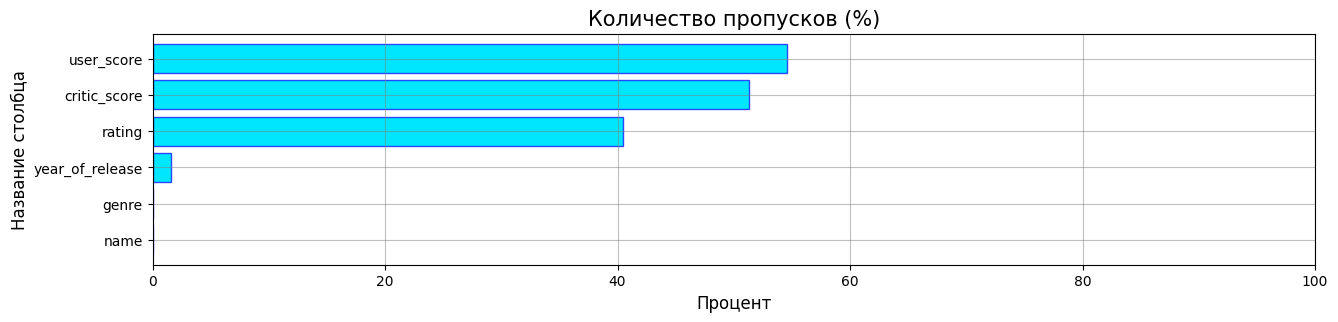

In [17]:
pass_value_barh(df)

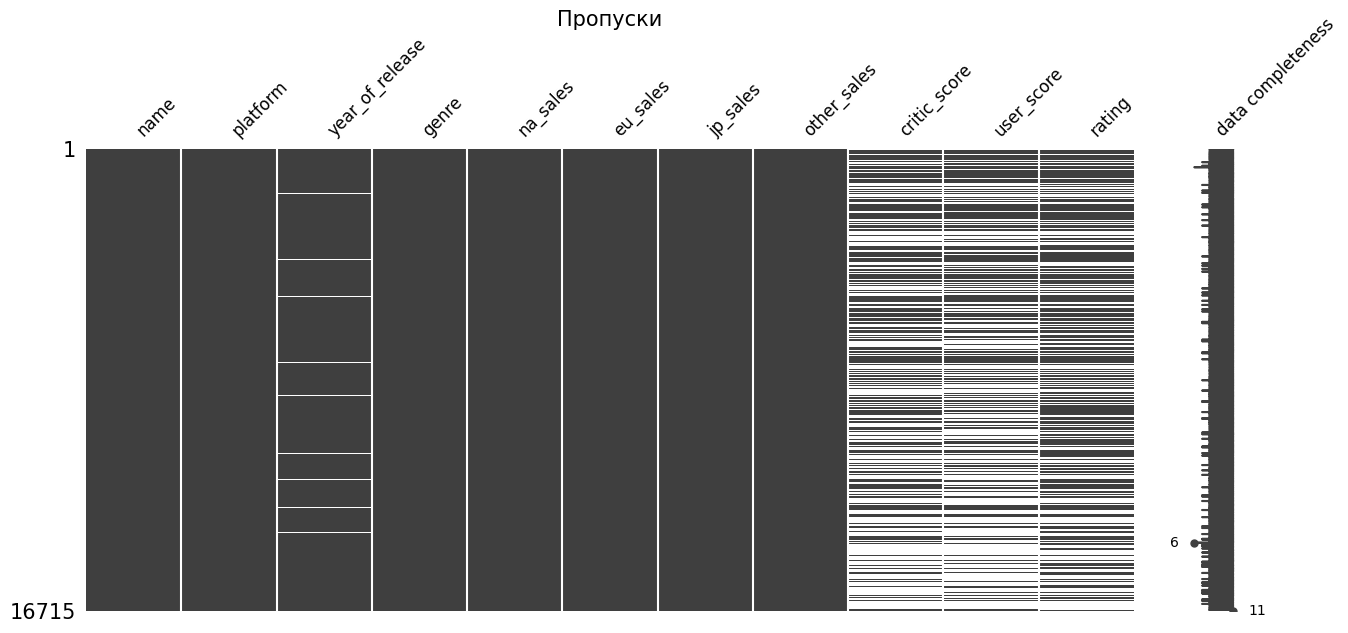

In [18]:
msno.matrix(df, labels=True, figsize=(15,6), fontsize=12)
plt.title('Пропуски', fontsize=15)

In [19]:
df[df['name'].isna()]

Эти две строки абсолютно не имеют информации для анализа, просто удалим их

In [20]:
df.dropna(subset=['name'], inplace=True)

Значения столбцов с рейтингом заполним нулями

In [21]:
df['critic_score'].fillna(0, inplace=True)
df['user_score'].fillna(0, inplace=True)
df['rating'].fillna('unknown', inplace=True)
df['year_of_release'].fillna(0, inplace=True)

In [22]:
changing_type(df, 'year_of_release', 'int64')

In [23]:
df.isna().sum()

In [24]:
df.dtypes

Избавимся от дубликатов

In [25]:
df.duplicated(subset=['name', 'genre', 'year_of_release', 'platform']).sum()

In [26]:
df.drop_duplicates(subset=['name', 'genre', 'year_of_release', 'platform'], inplace=True)

In [27]:
df.duplicated(subset=['name', 'genre', 'year_of_release', 'platform']).sum()

### Добавление столбца с суммарными продажами во всех регионах

In [28]:
#df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [29]:
df['total_sales'] = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

In [30]:
df.head(3)

**Вывод:**

Названия всех столбцов привели в практичный для анализа вид

**Изменение типа данных**

Изменили тип данных в столбце `user_score` c _object_ в _float_, так как рейтинг во многи строчках записан десятичной дробью. Была проблема в том, что было строковое значение _'tbd'_ обозначающее, что рейтинг еще не проставлен, это значение заменено на _'nan'_

Изменен тип данных в столбце с годом выхода игры в с _float_ в _int_, у года нет дробной части, поэтому лучше всего перевести в _int_.

**Пропуски**

Пропуски в `name` и `genre` были во всех важных столбцах, поэтому просто избавился от этих строк (всего 2 строки). Информации по этим играм вообще не было, но обе игры 1993 года, возможно была проблема в непонятном формате записи этих строк, что большинство стобцов преобразовались в _nan_. Не исключен человеческий фактор

Пропуски в столбце `year_of_release` заменили на нули, чтоб можно было перевести в тип _int_. Причины пропусков, скорее всего в человеческом факторе, не было информации по году выхода либо каие-то другие причины.

Столбцы с рейтингами `critic_score` и `user_score` имеют 50+ процентов пропусков, заменены на _нули_, так как игры индивидуальные, не всегда жанр играет главную роль, а качество самой игры. Скорее всего информации по рейтингу игр не было либо его еще не анонсировали, поэтому много пустых значений.

**Дубликат** был всего 1 

## Исследовательский анализ

### Количество игра по годам

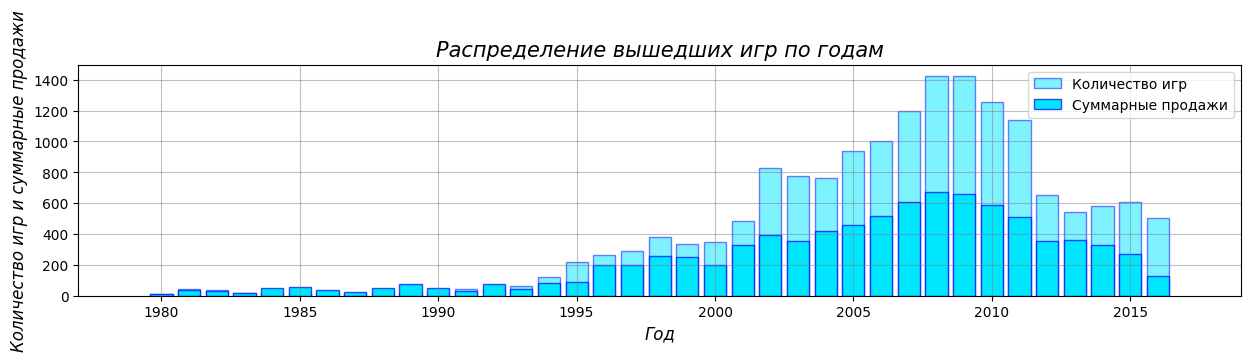

In [31]:
fig, ax = plt.subplots()
    
fig.set_size_inches(15, 3)

ax.bar(df['year_of_release'].value_counts().index,
       df['year_of_release'].value_counts(), 
       facecolor='#01e6ff', 
       edgecolor=(0, 0, 1, 0.7),
       alpha=0.5,
       label='Количество игр')

ax.bar(df.query('year_of_release > 0').groupby('year_of_release')['total_sales'].sum().index,
       df.query('year_of_release > 0').groupby('year_of_release')['total_sales'].sum(), 
       facecolor='#01e6ff', 
       edgecolor=(0, 0, 1, 0.7),
       label='Суммарные продажи')

ax.set_title('Распределение вышедших игр по годам', fontsize=15, fontstyle='italic')
ax.set_xlim(df[df['year_of_release'] > 0]['year_of_release'].min() - 3, df['year_of_release'].max() + 3)
ax.set_xlabel('Год', fontsize=12, fontstyle='italic')
ax.set_ylabel('Количество игр и суммарные продажи', fontsize=12, fontstyle='italic')
ax.grid(color='grey', alpha=0.5)
ax.legend();

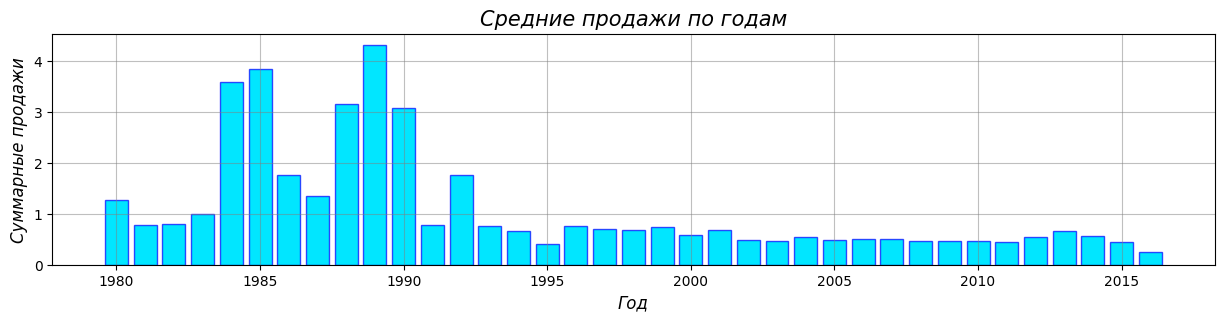

In [32]:
fig, ax = plt.subplots()
    
fig.set_size_inches(15, 3)
ax.bar(df.query('year_of_release > 0').groupby('year_of_release')['total_sales'].mean().index,
       df.query('year_of_release > 0').groupby('year_of_release')['total_sales'].mean(), 
       facecolor='#01e6ff', 
       edgecolor=(0, 0, 1, 0.7))
ax.set_title('Средние продажи по годам', fontsize=15, fontstyle='italic')
ax.set_xlabel('Год', fontsize=12, fontstyle='italic')
ax.set_ylabel('Суммарныx продажи', fontsize=12, fontstyle='italic')
ax.grid(color='grey', alpha=0.5)

Среднее и медиана до 1995 года

In [33]:
df.query('0 < year_of_release < 1995')['total_sales'].mean()

In [34]:
df.query('0 < year_of_release < 1995')['total_sales'].median()

Среднее и медиана после 1994 года

In [35]:
df.query('year_of_release >= 1995')['total_sales'].mean()

In [36]:
df.query('year_of_release >= 1995')['total_sales'].median()

С 1980-х годов началось зарождение эпохи видеоигр, естественно для многих людей это был просто бум. Несмотря на малое количество игр, в среднем продаж до 1995 было больше, чем после 1994, но суммарно продаж было больше после 1995 из-за большого количества игр.

### Продажи по платформам

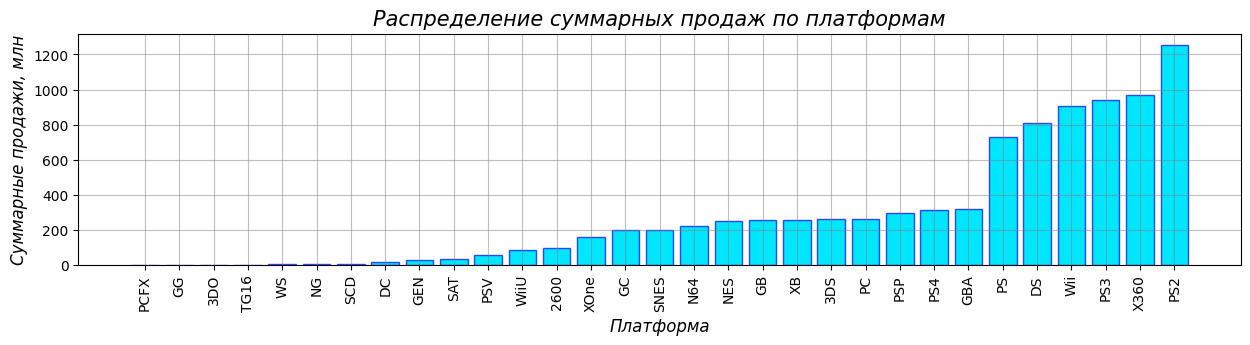

In [37]:
fig, ax = plt.subplots()
    
fig.set_size_inches(15, 3)
ax.bar(df.groupby('platform')['total_sales'].sum().sort_values().index,
        df.groupby('platform')['total_sales'].sum().sort_values(),
       facecolor='#01e6ff', 
       edgecolor=(0, 0, 1, 0.7))
ax.set_title('Распределение суммарных продаж по платформам', fontsize=15, fontstyle='italic')
ax.set_xlabel('Платформа', fontsize=12, fontstyle='italic')
ax.set_ylabel('Суммарные продажи, млн', fontsize=12, fontstyle='italic')
ax.grid(color='grey', alpha=0.5)
plt.xticks(fontsize=10, rotation ='vertical');

In [38]:
top_5_platform = df.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5).index
top_5_platform

In [39]:
def distribution_platform(data, platform, group, column_agg):
    x_sum = data.query('platform == @platform and year_of_release > 0').groupby('year_of_release')['total_sales'].sum()
    x_count = data.query('platform == @platform and year_of_release > 0').groupby('year_of_release')['total_sales'].count()
    
    
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 3)

    ax.bar(x_count.index, x_count, facecolor='#01e6ff', edgecolor=(0, 0, 1, 0.7), alpha=0.5, label='Кол-во игр')
    ax.bar(x_sum.index, x_sum, facecolor='#01e6ff', edgecolor=(0, 0, 1, 0.7), label='Сумм. продажи')
    ax.set_title(f'Распределение по платформе {platform}', fontsize=15, fontstyle='italic')
    ax.set_xlabel('Год', fontsize=12, fontstyle='italic')
    ax.set_ylabel('''Количество игр и 
    суммарные продажи, млн''', fontsize=12, fontstyle='italic')
    ax.legend()
    ax.grid(color='grey', alpha=0.5)

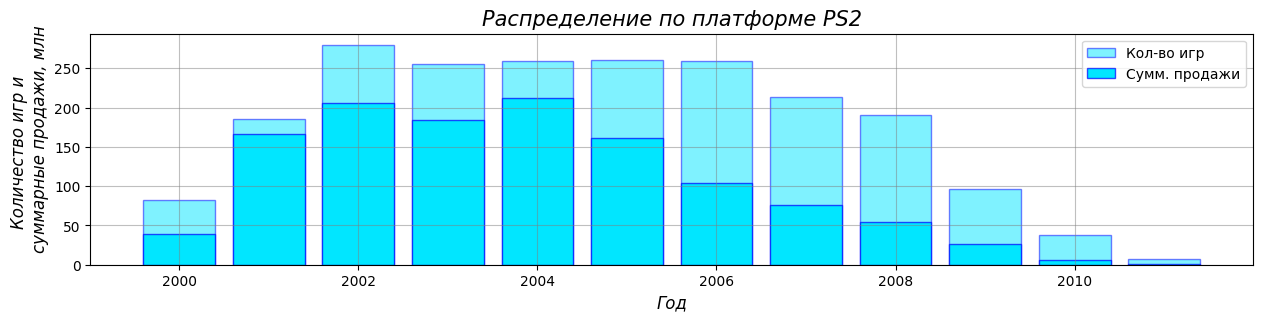

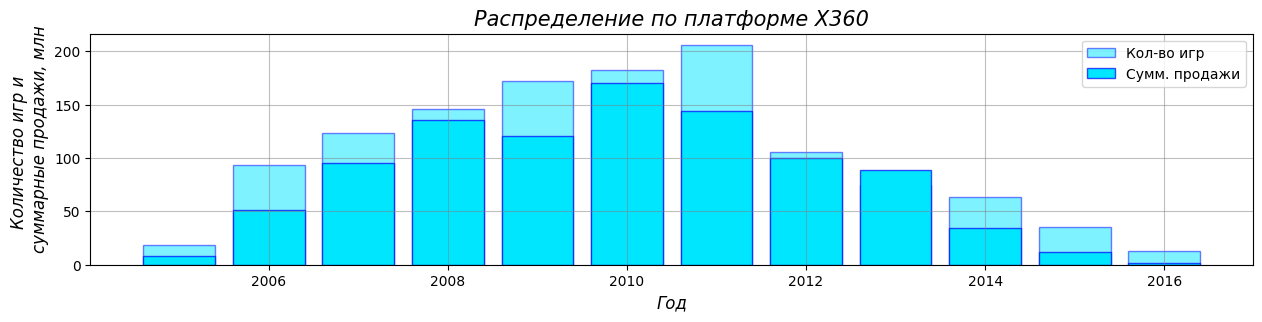

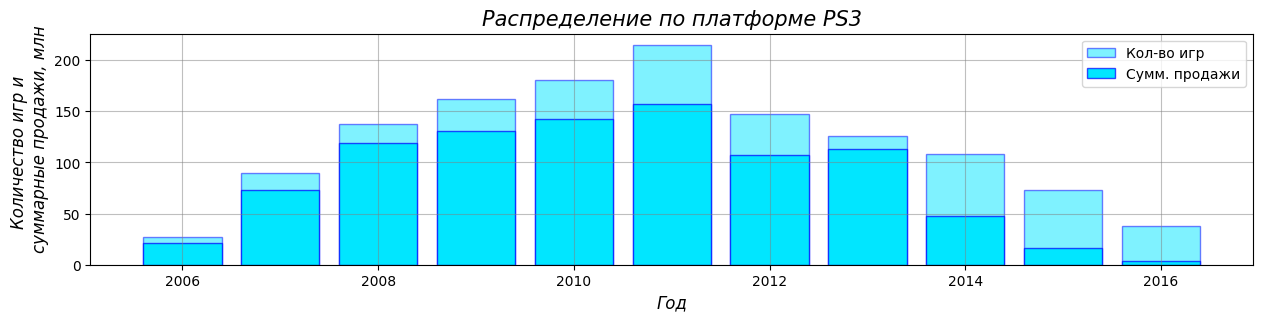

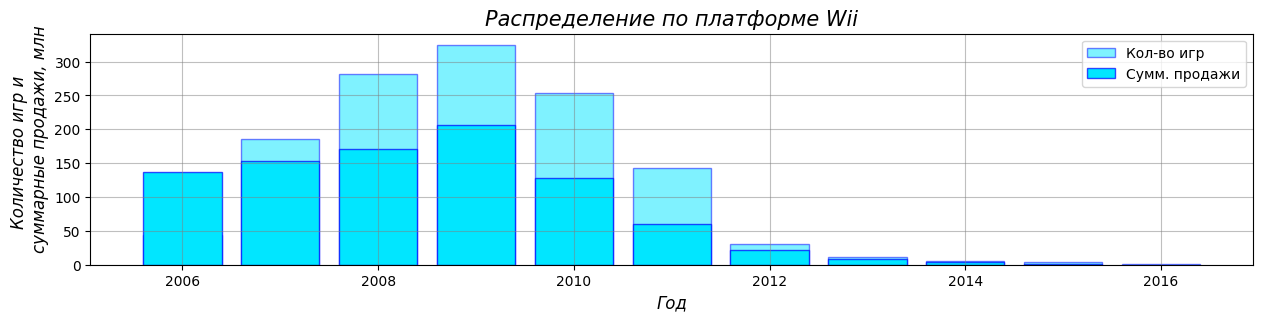

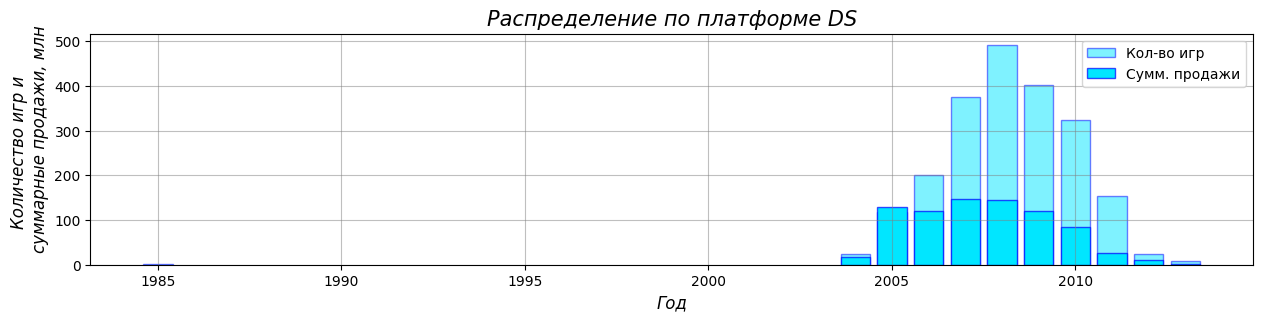

In [40]:
for platform in top_5_platform:
    distribution_platform(df, platform, 'year_of_release', 'total_sales')

Топ 5 по продажам за все время платформы (_`'PS2', 'X360', 'PS3', 'Wii', 'DS'`_) жили около 10 лет. Как говорится все устаревает рано или поздно и на их место приходит что-то новое.

### Выделим актуальные данные для прогноза на 2017 год

Закат популярных платформ начался с 2010-2012 года, посмотрим какие платформы заменили их

In [41]:
df_actual = df.query('year_of_release > 2012')
df_actual.head()

Посмотрим какие платформы лидируют по продажам 2013-2016гг.

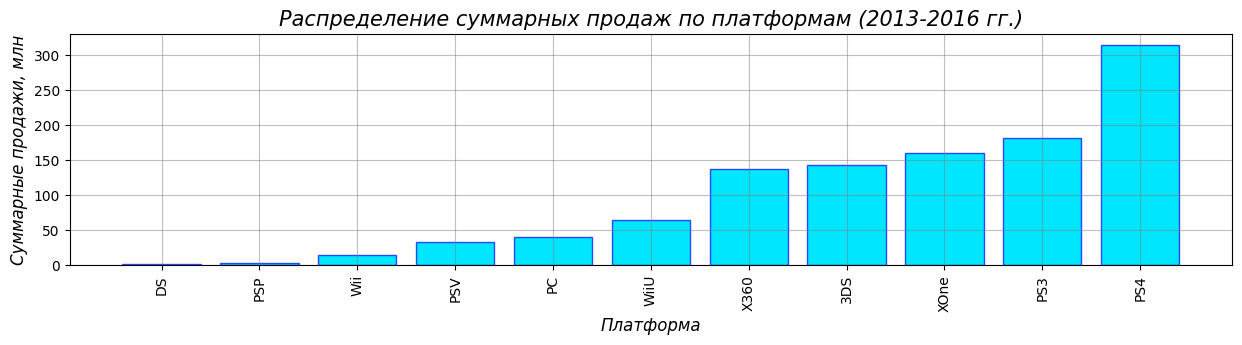

In [42]:
fig, ax = plt.subplots()
    
fig.set_size_inches(15, 3)
ax.bar(df_actual.groupby('platform')['total_sales'].sum().sort_values().index,
        df_actual.groupby('platform')['total_sales'].sum().sort_values(),
       facecolor='#01e6ff', 
       edgecolor=(0, 0, 1, 0.7))
ax.set_title('Распределение суммарных продаж по платформам (2013-2016 гг.)', fontsize=15, fontstyle='italic')
ax.set_xlabel('Платформа', fontsize=12, fontstyle='italic')
ax.set_ylabel('Суммарные продажи, млн', fontsize=12, fontstyle='italic')
ax.grid(color='grey', alpha=0.5)
plt.xticks(fontsize=10, rotation ='vertical');

In [43]:
top_5_platform_actual = df_actual.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5).index
top_5_platform_actual

Посмотрим на распределение каждой платформы

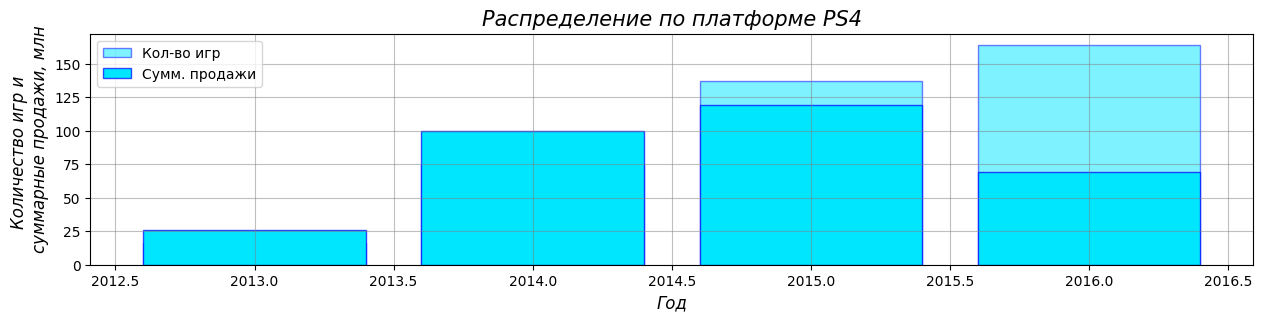

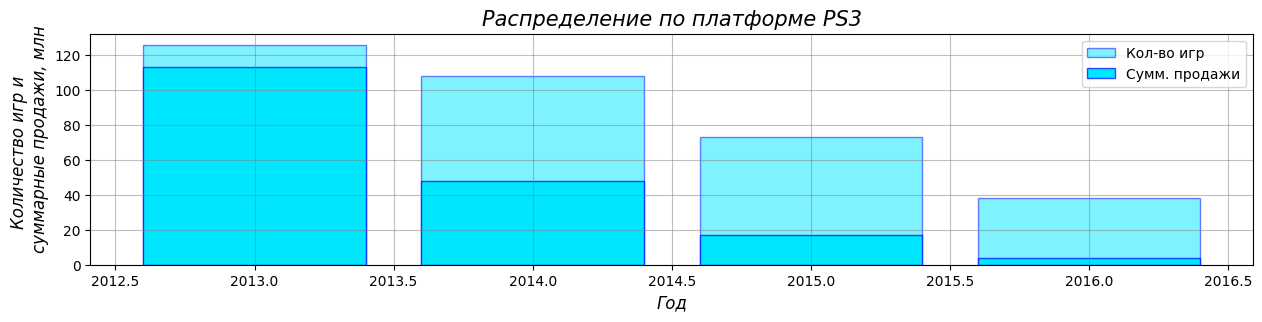

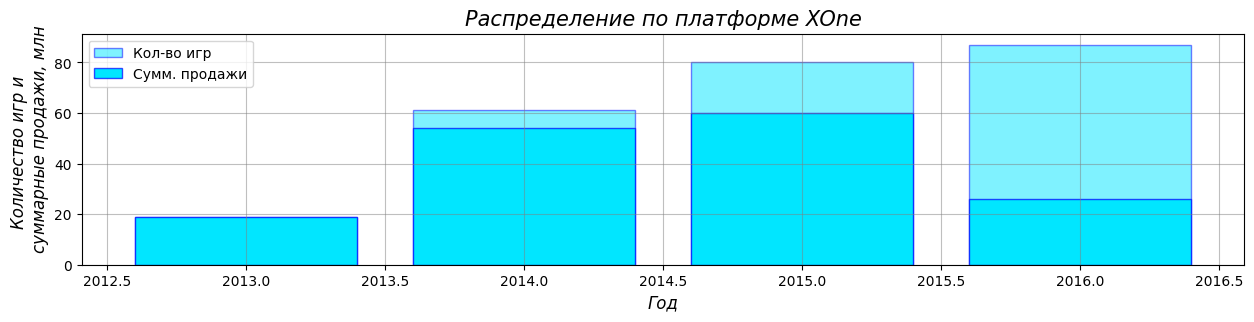

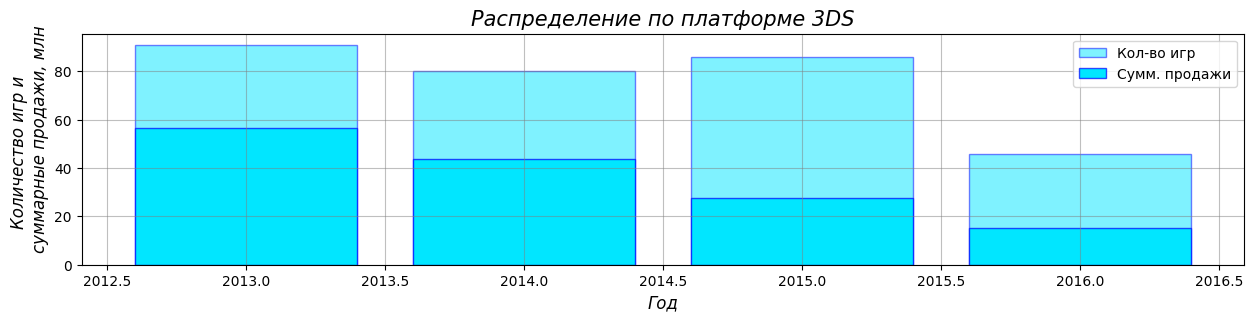

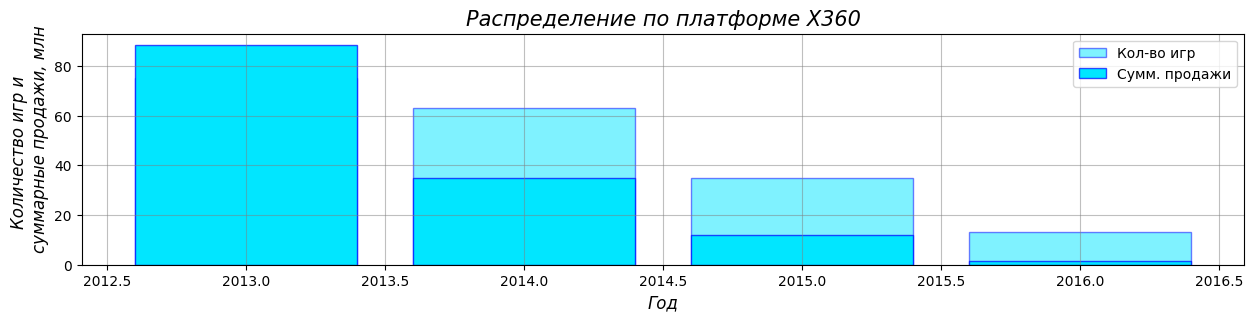

In [44]:
for platform in top_5_platform_actual:
    distribution_platform(df_actual, platform, 'year_of_release', 'total_sales')

In [45]:
df_actual.query('platform == "PS4" and year_of_release == 2016')['total_sales'].sum()

In [46]:
round(df_actual.query('platform == "XOne" and year_of_release == 2016')['total_sales'].sum(), 2)

На всех платформах в 2016 году наблюдается спад продаж относительно 2015 года, но все еще большое кочилество продаж имеется у платформ PS4 и XOne (69.25 и 26.15 соответственно)

### Диаграмма размаха по платформам

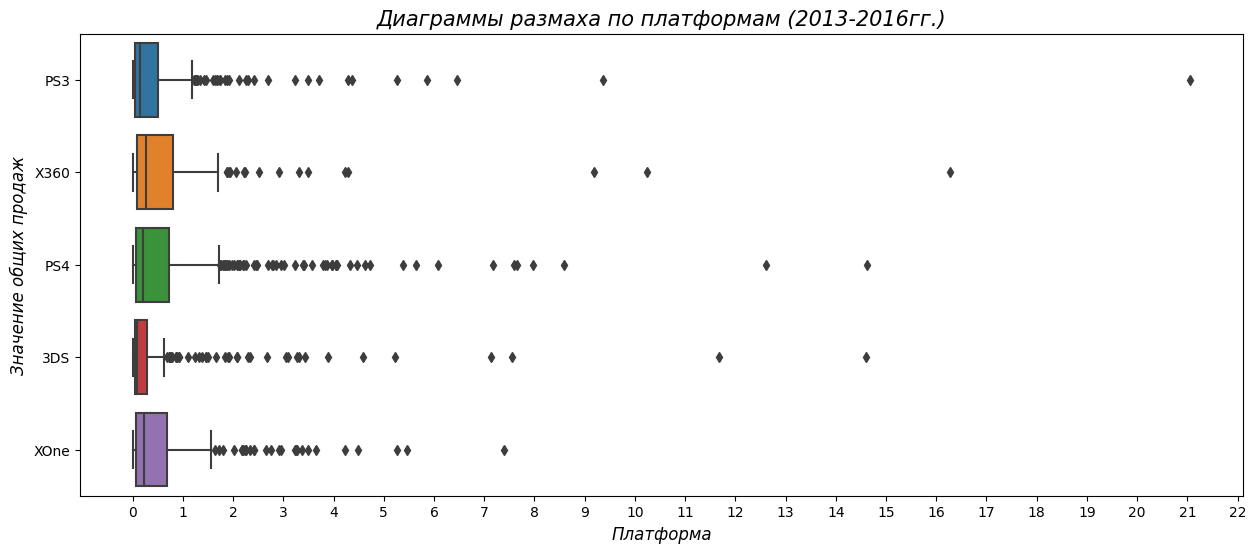

In [47]:
plt.figure(figsize=(15,6))
sns.boxplot(x='total_sales',
            y='platform',
            data=df_actual.query('platform in @top_5_platform_actual'),
            orient='h')
plt.title('Диаграммы размаха по платформам (2013-2016гг.)', fontsize=15, fontstyle='italic')
plt.xlabel('Платформа', fontsize=12, fontstyle='italic')
plt.ylabel('Значение общих продаж', fontsize=12, fontstyle='italic')
plt.xticks(np.arange(0, 23, step=1));

Межквартильный размах у всех меньше единицы, основные продажи получаются за счет конкретных игр

### Влияние оценок пользователей и критиков на продажи

Посмотрим как влияют оценки критиков на общие продажи по самой популярной платформе

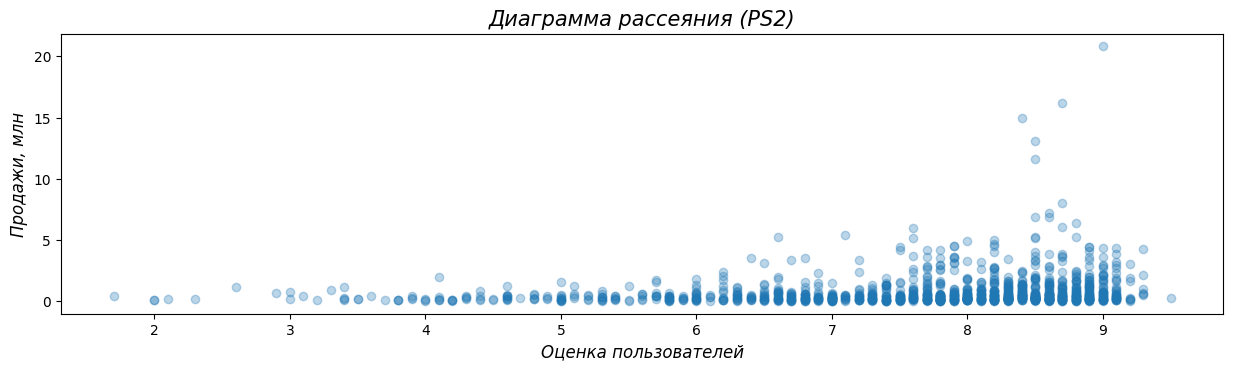

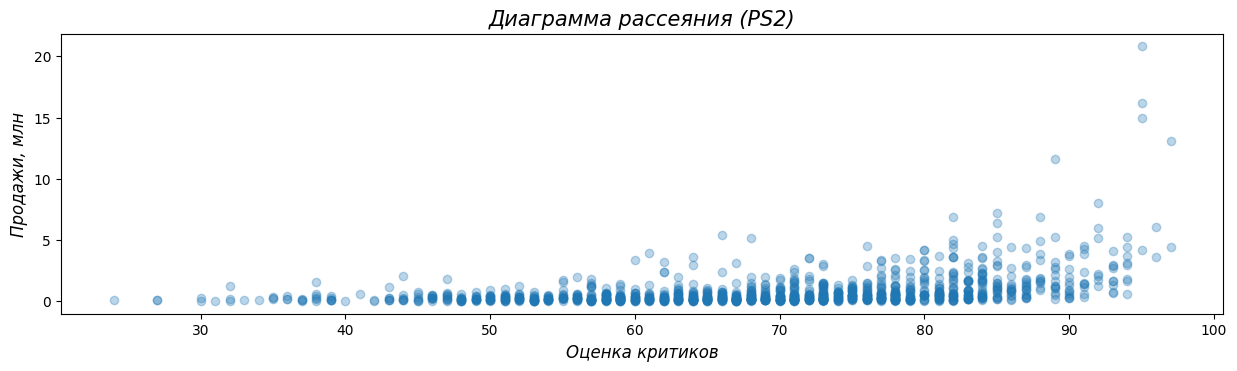

In [48]:
plt.figure(figsize=(15, 8))

plt.subplot(211)
plt.scatter(df.query('platform == "PS2" and user_score > 0')['user_score'],
            df.query('platform == "PS2" and user_score > 0')['total_sales'], 
            alpha=0.3)
plt.title('Диаграмма рассеяния (PS2)', fontsize=15, fontstyle='italic')
plt.xlabel('Оценка пользователей', fontsize=12, fontstyle='italic')
plt.ylabel('Продажи, млн', fontsize=12, fontstyle='italic')
plt.show()

print('Коэффициент корреляции:')
print(round(df.query('platform == "PS2" and user_score > 0')['total_sales'] \
.corr(df.query('platform == "PS2" and user_score > 0')['user_score']), 2))

plt.figure(figsize=(15, 8))

plt.subplot(212)
plt.scatter(df.query('platform == "PS2" and critic_score > 0')['critic_score'],
            df.query('platform == "PS2" and critic_score > 0')['total_sales'],
            alpha=0.3)
plt.title('Диаграмма рассеяния (PS2)', fontsize=15, fontstyle='italic')
plt.xlabel('Оценка критиков', fontsize=12, fontstyle='italic')
plt.ylabel('Продажи, млн', fontsize=12, fontstyle='italic')
plt.show()

print('Коэффициент корреляции:')
print(round(df.query('platform == "PS2" and critic_score > 0')['total_sales'] \
.corr(df.query('platform == "PS2" and critic_score > 0')['critic_score']), 2))

Посмотрим на одну из топовых платформ с 2013 года (PS4)

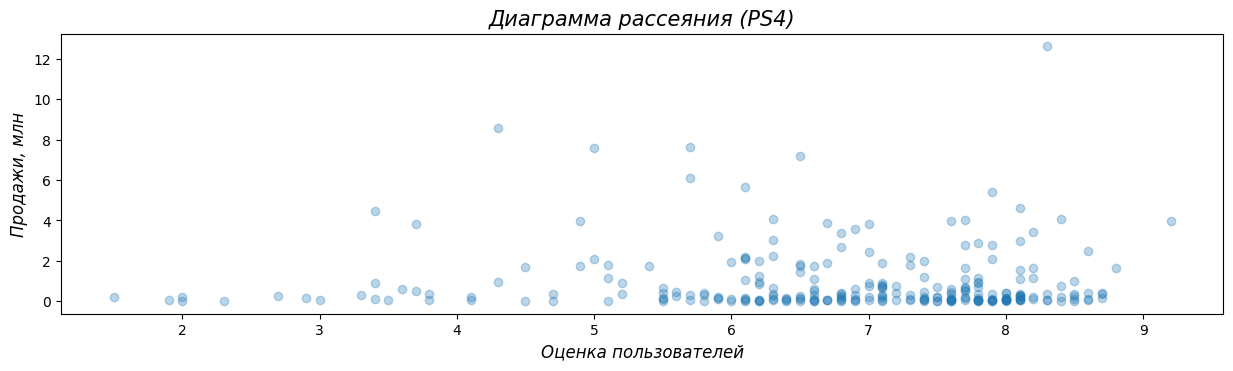

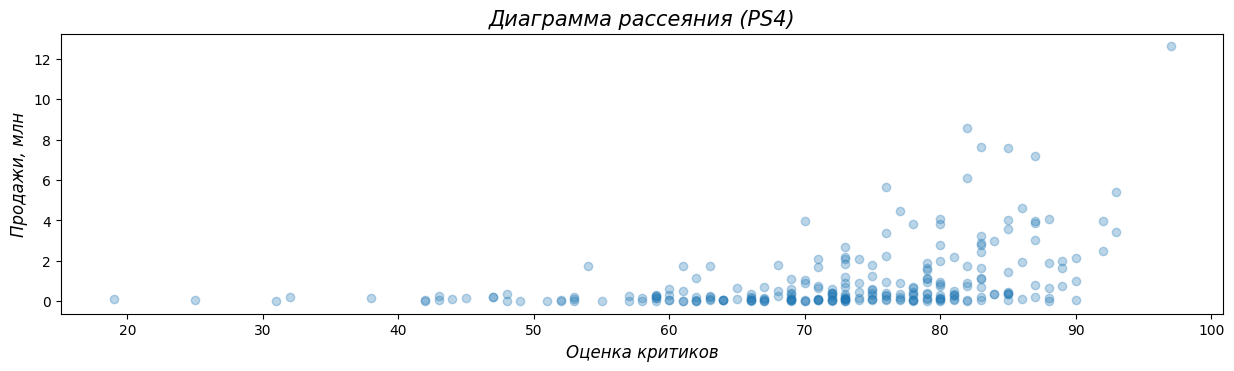

In [49]:
plt.figure(figsize=(15, 8))

plt.subplot(211)
plt.scatter(df_actual.query('platform == "PS4" and user_score > 0')['user_score'],
            df_actual.query('platform == "PS4" and user_score > 0')['total_sales'], 
            alpha=0.3)
plt.title('Диаграмма рассеяния (PS4)', fontsize=15, fontstyle='italic')
plt.xlabel('Оценка пользователей', fontsize=12, fontstyle='italic')
plt.ylabel('Продажи, млн', fontsize=12, fontstyle='italic')
plt.show()

print('Коэффициент корреляции:')
print(round(df_actual.query('platform == "PS4" and user_score > 0')['total_sales'] \
.corr(df_actual.query('platform == "PS4" and user_score > 0')['user_score']), 2))

plt.figure(figsize=(15, 8))

plt.subplot(212)
plt.scatter(df_actual.query('platform == "PS4" and critic_score > 0')['critic_score'],
            df_actual.query('platform == "PS4" and critic_score > 0')['total_sales'],
            alpha=0.3)
plt.title('Диаграмма рассеяния (PS4)', fontsize=15, fontstyle='italic')
plt.xlabel('Оценка критиков', fontsize=12, fontstyle='italic')
plt.ylabel('Продажи, млн', fontsize=12, fontstyle='italic')
plt.show()

print('Коэффициент корреляции:')
print(round(df_actual.query('platform == "PS4" and critic_score > 0')['total_sales'] \
.corr(df_actual.query('platform == "PS4" and critic_score > 0')['critic_score']), 2))

Корреляция для для столбца с оценками критиков и общими продажами выше чем между оценками пользователей и общими продажами. Корреляции маленьки, но все же чем больше рейтин тем больше точек находятся выше т.е количество продаж увеличивается, на других платформах скорее всего будет тоже самое, ведь многие ориентируются именно на отзывы, на обзоры, перед тем как покупать ту или иную игру.

На PS4 кореляция между оценками пользователей и продажами почти равна нулю. Значит можно сделать вывод, что в основном на продажи влияют именно отзывы критиков

### Распределения по жанрам

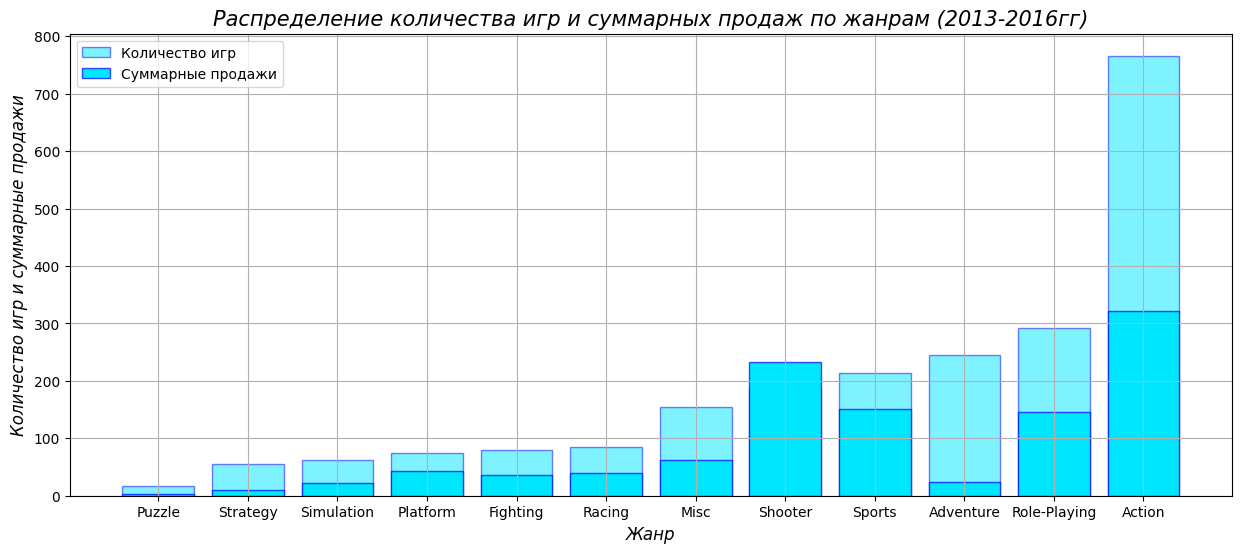

In [50]:
plt.figure(figsize=(15,6))

plt.bar(df_actual.groupby('genre')['total_sales'].count().sort_values().index, 
        df_actual.groupby('genre')['total_sales'].count().sort_values(),
        color='#01e6ff',
        edgecolor=(0, 0, 1, 0.7),
        alpha = 0.5,
        label='Количество игр')
plt.bar(df_actual.groupby('genre')['total_sales'].sum().sort_values().index, 
        df_actual.groupby('genre')['total_sales'].sum().sort_values(),
        color='#01e6ff',
        edgecolor=(0, 0, 1, 0.7),
        label='Суммарные продажи')

plt.title('Распределение количества игр и суммарных продаж по жанрам (2013-2016гг)', fontsize=15, fontstyle='italic')
plt.xlabel('Жанр', fontsize=12, fontstyle='italic')
plt.ylabel('Количество игр и суммарные продажи', fontsize=12, fontstyle='italic')
plt.legend()
plt.grid()
plt.show()

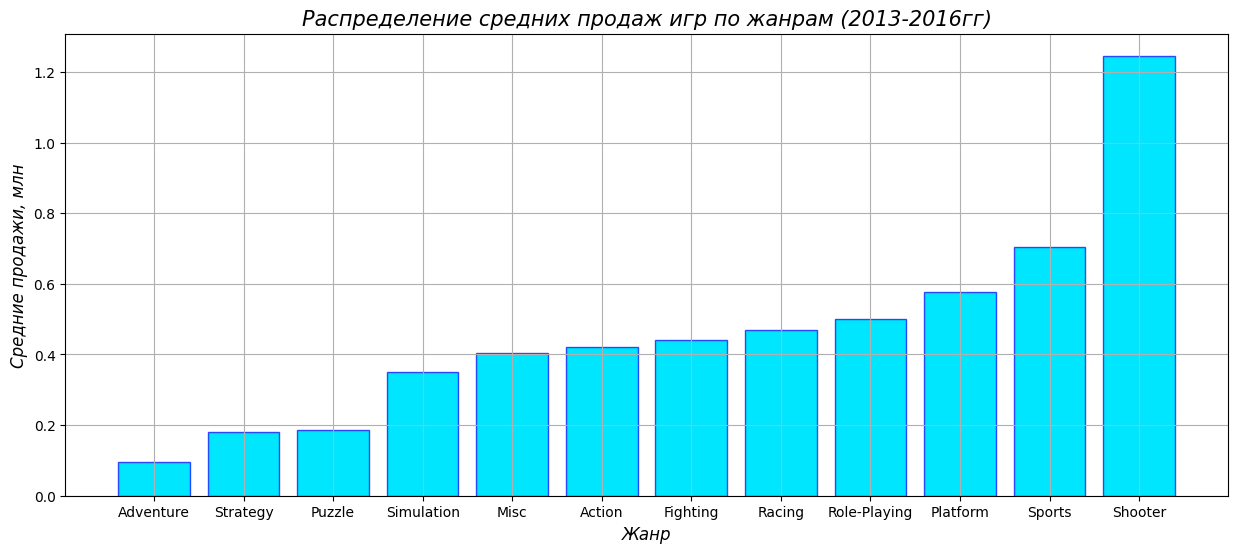

In [51]:
plt.figure(figsize=(15,6))
plt.bar(df_actual.groupby('genre')['total_sales'].mean().sort_values().index, 
        df_actual.groupby('genre')['total_sales'].mean().sort_values(),
        color='#01e6ff',
        edgecolor=(0, 0, 1, 0.7))
plt.title('Распределение средних продаж игр по жанрам (2013-2016гг)', fontsize=15, fontstyle='italic')
plt.xlabel('Жанр', fontsize=12, fontstyle='italic')
plt.ylabel('Средние продажи, млн', fontsize=12, fontstyle='italic')
plt.grid()
plt.show()

**Вывод:**

С 1980-х годов по 1995-е, игр выходило мало, но средние продажи были намного больше по сравнению с периодом начиная с 1995 (в некоторые годы аж в 4 раза). С 1995 года начался рост количества игр.

Топ 5 по продажам за все время платформы **_PS2, X360, PS3, Wii, DS_**. Время жизни каждой из них примерно 10 лет.

Выделили актуальный период 2013-2016 года. Топ-5 платформ по продажам за этот период **_PS4, PS3, XOne, 3DS, X360_**. В 2016 году наблюдается спад продаж по перечисленным платформам, но при это на платформах **PS4** и **XOne** все еще достаточно большие продажи (69.25 и 26.15 соответственно), также на этих двух платформах наблюдается рост количества игр, скорее всего спад на них потому, что информация за 2016 год неполная.

На диаграмме размаха видно, что межквартильный размах у всех плюс минус одинаковы (меньше 1). Выбиваются в лидеры по продажам платформы за счет конкретных игр

Диаграммы рассеяния показывают, что при больших оценках больше игр у которых высокие продажи независимо от того оценки критиков или оценки пользователей. Но **коэфиициенты кореляции** между продажами и оценками все же низкие

Коэффициенты корреляции:
- Для пользователей: 0.17
- Для критиков: 0.4

Больше всего продаж за 2013-2016гг. у жанров **Action, Shooter, Sports, Role-Playing**, можно выделить два жанра `Action` лидирует за счет того, что большое количество игр именно этого жанра, а вот игр жанра `Shooter` намного меньше, но все же он выравается в лидеры поскольку имеет хорошие средние продажи (в 2 раза больше относительно остальных). Большинство жанров сопоставимы с `Action` по средним продажам, но по количеству игр сильно отстают

## Портреты пользователей по регионам

In [52]:
def top_5_bar (data, region='na_sales', group='platform'):
    
    x = ((df.groupby(group)[region].sum() / \
          df[region].sum()).sort_values(ascending=False) * 100).head().index
    y = ((df.groupby(group)[region].sum() / \
          df[region].sum()).sort_values(ascending=False) * 100).head()
    
    plt.figure(figsize=(15,3))

    plt.bar(x, y, color='#01e6ff', edgecolor=(0, 0, 1, 0.7), width=0.5)

    if group == 'platform':
        if region == 'na_sales':
            plt.title('Топ-5 платформ в Северной Америке', fontsize=15, fontstyle='italic')
        elif region == 'eu_sales':
            plt.title('Топ-5 платформ в Европе', fontsize=15, fontstyle='italic')
        elif region == 'jp_sales':
            plt.title('Топ-5 платформ в Японии', fontsize=15, fontstyle='italic')
        plt.xlabel('Платформа', fontsize=12, fontstyle='italic')
    
    elif group == 'genre':
        if region == 'na_sales':
            plt.title('Топ-5 жанров игр в Северной Америке', fontsize=15, fontstyle='italic')
        elif region == 'eu_sales':
            plt.title('Топ-5 жанров игр в Европе', fontsize=15, fontstyle='italic')
        elif region == 'jp_sales':
            plt.title('Топ-5 жанров игр в Японии', fontsize=15, fontstyle='italic')
        plt.xlabel('Жанр', fontsize=12, fontstyle='italic')
    
    plt.ylabel('Процент продаж', fontsize=12, fontstyle='italic')
    plt.grid()
    plt.show()

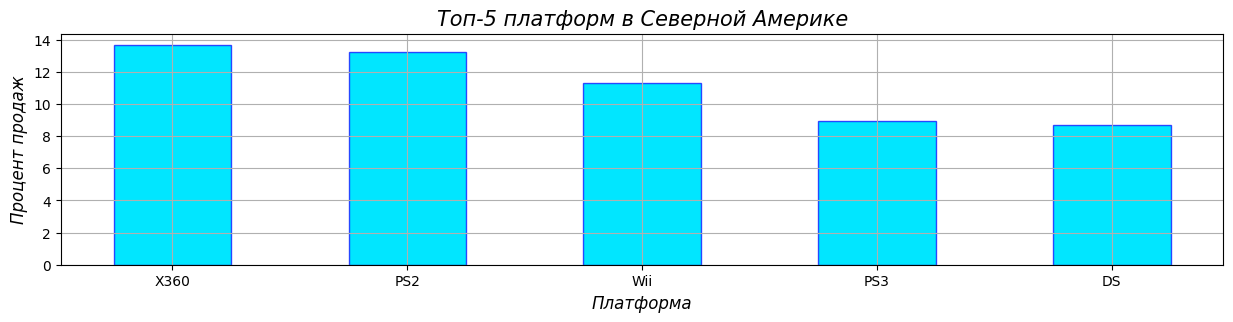

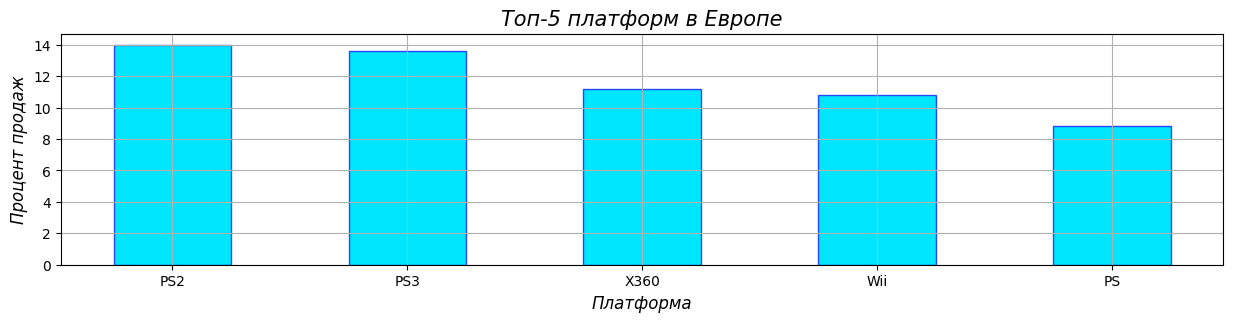

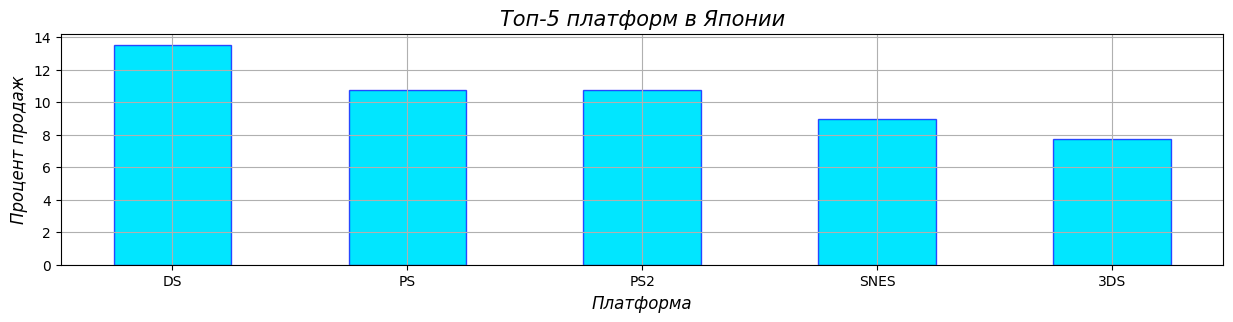

In [53]:
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    top_5_bar(df, region, 'platform')

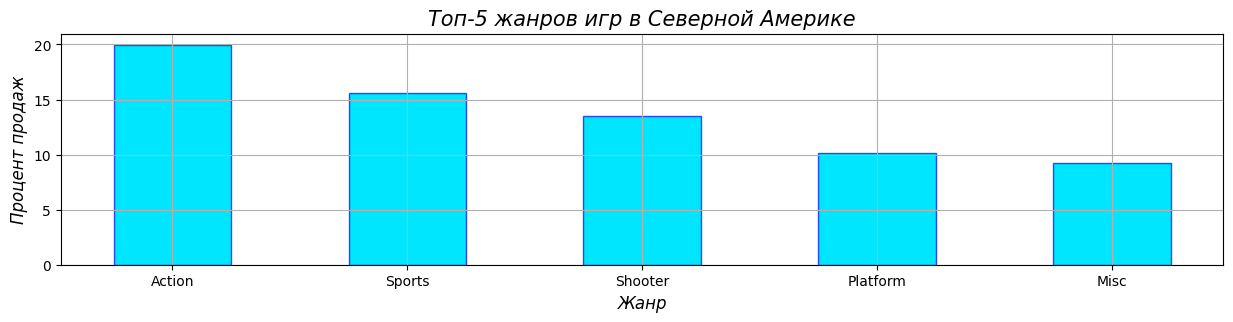

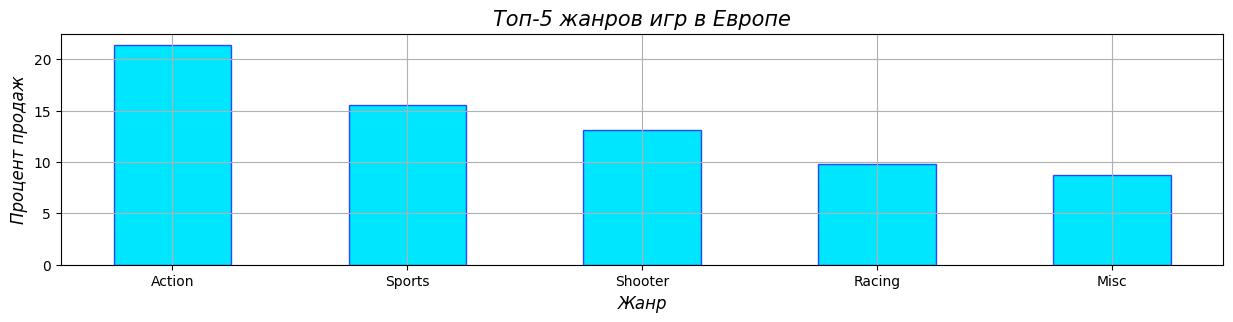

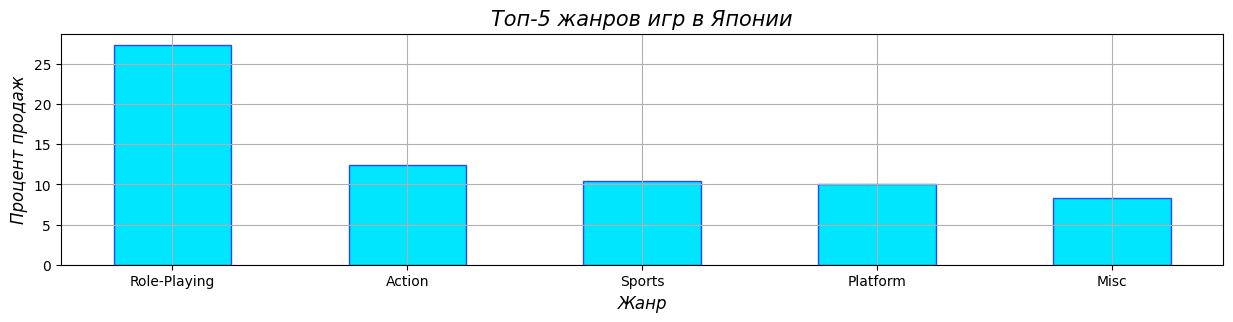

In [54]:
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    top_5_bar(df, region, 'genre')

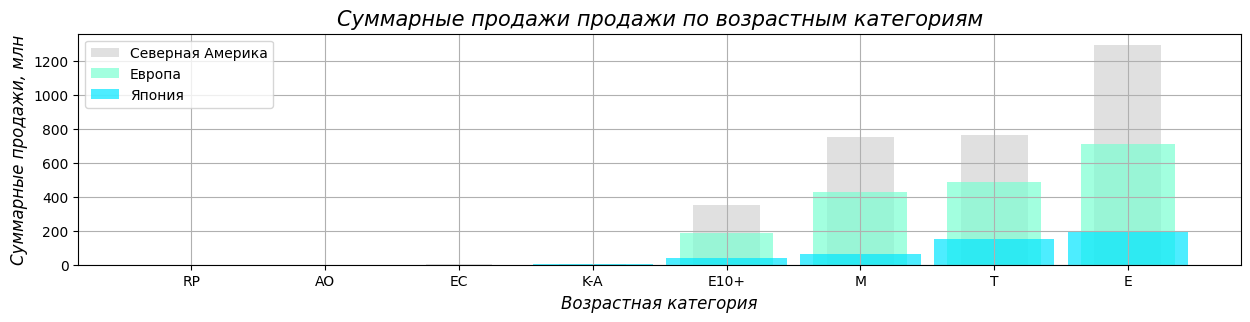

In [55]:
plt.figure(figsize=(15,3))

plt.bar(df.query('rating != "unknown"').groupby('rating')['na_sales'].sum().sort_values().index,
        df.query('rating != "unknown"').groupby('rating')['na_sales'].sum().sort_values(), 
        color='#d4d4d4', 
        width=0.5,
        alpha=0.7,
        label='Северная Америка')

plt.bar(df.query('rating != "unknown"').groupby('rating')['na_sales'].sum().sort_values().index,
        df.query('rating != "unknown"').groupby('rating')['eu_sales'].sum().sort_values(), 
        color='#7bffd2',  
        width=0.7,
        alpha=0.7,
        label='Европа')

plt.bar(df.query('rating != "unknown"').groupby('rating')['na_sales'].sum().sort_values().index,
        df.query('rating != "unknown"').groupby('rating')['jp_sales'].sum().sort_values(), 
        color='#01e6ff', 
        width=0.9,
        alpha=0.7,
        label='Япония')
plt.title('Суммарные продажи продажи по возрастным категориям', fontsize=15, fontstyle='italic')
plt.xlabel('Возрастная категория', fontsize=12, fontstyle='italic')
plt.ylabel('Суммарные продажи, млн', fontsize=12, fontstyle='italic')
plt.legend()
plt.grid()

- **EC** (Early childhood) — Для детей младшего возраста
- **E** (Everyone) — Для всех
- **E10+** (Everyone 10 and older) — Для всех от 10 лет и старше
- **T** (Teen) — Подросткам
- **AO** (Adults Only 18+) — Только для взрослых
- **RP** (Rating Pending) — Рейтинг ожидается
- **K-A** (Kids to Adults) — Для детей – для тех, кто уже научился говорить и держать джойстик
- **М 17+** (Mature)

**Вывод:**

Портрер пользователя Северной Америки:

- Топ-5 платформ **X360, PS2, Wii, PS3, DS**
- Топ-5 жанров **Action, Sports, Shooter, Platform, Misc**

Портрер пользователя в Европе:

- Топ-5 платформ **PS2, PS3, X360, Wii, PS**
- Топ-5 жанров **Action, Sports, Shooter, Racing, Misc**

Портрет пользователя в Японии:

- Топ-5 платформ **DS, PS, PS2, SNES, 3DS**
- Топ-5 жанров **Role-Playing, Action, Sports, Platform, Misc**

Больше всего берут игры рейтинга **E** при чем независимо от региона. Все регионы предпочитают одни и те же возрастные категории игр различается только количество суммарных продаж в зависимиости от региона, это уже скорее всего зависит от количество пользователей этих регионов.

## Проверка гипотез

Проверим гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые (двусторонняя гипотеза).

H0 - средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

H1 - средние пользовательские рейтинги платформ Xbox One и PC разные.

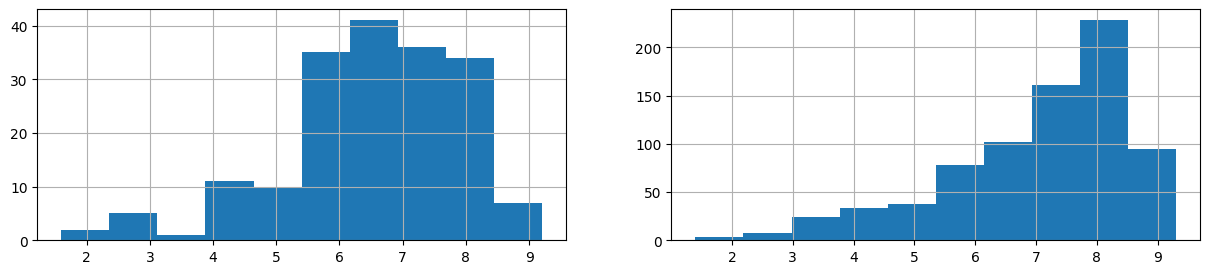

In [56]:
plt.figure(figsize=(15,3))
plt.subplot(121)
df.query('platform == "XOne" and user_score > 0')['user_score'].hist()
plt.subplot(122)
df.query('platform == "PC" and user_score > 0')['user_score'].hist()

In [57]:
alpha = 0.05
results = st.ttest_ind(df.query('platform == "XOne" and user_score > 0')['user_score'],
             df.query('platform == "PC" and user_score > 0')['user_score'])
if results.pvalue > alpha:
    print('Нулевая гипотеза не может быть отвергнута')
else:
    print('Нулевая гипотеза отвергнута в пользу альтернативной')
print(f'pvalue - {results.pvalue}')

Проверим гипотезу о том разные ли средние пользовательские рейтинги жанров Action и Sports

H0 - средние пользовательские рейтинги жанров Action и Sports одинаковые.

H1 - средние пользовательские рейтинги жанров Action и Sports разные.

In [58]:
alpha = 0.05
results = st.ttest_ind(df.query('genre == "Action" and user_score > 0')['user_score'],
             df.query('genre == "Sports" and user_score > 0')['user_score'])
if results.pvalue > alpha:
    print('Нулевая гипотеза не может быть отвергнута')
else:
    print('Нулевая гипотеза отвергнута в пользу альтернативной')
print(f'pvalue - {results.pvalue}')

## Вывод

**Предобработка данных**

- Названия столбцов переименованы (привели в нижний регистр)
- В некоторых столбцах был некорректный тип данных (изменили тип данных)
- 2 строки имели пропуски во всех важных признаках (удалены эти пропуски)
- В столбце с годом выхода игр пропуски заменены на 'unknown'
- Столбцы с оценками имели больше половины пропусков от всех данных (заменены нулями)
- Пропуски с рейтингом ESRB заменены значением 'unknown'
- Дубликатов по основным признакам было всего 1 (удален)

**Исследовательский анализ**

- Пик выхода игр и соответственно продаж приходится на 2007-2010 годы.
- Топ-5 платформ по продажам за весь переиод в порядке убывания **_PS2, X360, PS3, Wii, DS_**.
- Время жизни платформы составляет примерно 10 лет.
- Топ-5 платформ по продажам в период с 2013 года **_PS4, PS3, XOne, 3DS, X360_**
- В 2016 году наблюдается спад продаж по этим 5 платформам в основном это видно по распределению, но у платформ **PS4** и **XOne** несмотря на спад продаж имеется рост количества выпущеных игр. Скорее всего такая ситуация из-за неполноты данных за 2016 год и возможно эти платформы идут вверх.
- Платформы выбиваются в лидеры за счет того, что на них выпускается много качественных игр, которые обеспечивают высокие продажи
- Также на продажи влияют отзывы в основном от критиков, если рейтинг у игры высокий, то и продажи будут высокими, хотя коэффициенты корреляции довольно маленькие (0.4 для критиков)
- Любимые жанры в период с 2013 года это **Action, Shooter, Sports, Role-Playing**. Из них выделяются два жанра Action имеет самое большое количество игр и соотвественно большое колиество продаж, а вот шутеры при небольшом количестве игр относительно жанра Action имеет хорошие средние продажи (1.2 млн). Большинство жанров сопоставимы с `Action` по средним продажам (0.4 млн), но по количеству игр сильно отстают


**Портреты пользователей с разных регионов**

Портрер пользователя Северной Америки:

- Топ-5 платформ **X360, PS2, Wii, PS3, DS**
- Топ-5 жанров **Action, Sports, Shooter, Platform, Misc**

Портрер пользователя в Европе:

- Топ-5 платформ **PS2, PS3, X360, Wii, PS**
- Топ-5 жанров **Action, Sports, Shooter, Racing, Misc**

Портрет пользователя в Японии:

- Топ-5 платформ **DS, PS, PS2, SNES, 3DS**
- Топ-5 жанров **Role-Playing, Action, Sports, Platform, Misc**

Жанры у пользователей Северной Америки и Европы практически одинаковые лидирует у них жанр Action. Японцы больше предпочитаю жанр Role-Playing. Можно заметить, что в Европе больше всего любят платформы PlayStation.

Больше всего берут игры рейтинга **E** при чем независимо от региона. Все регионы предпочитают одни и те же возрастные категории игр различается только количество суммарных продаж в зависимиости от региона, это уже скорее всего зависит от количество пользователей этих регионов.

**Проверка гипотез**

- Средние пользовательские рейтинги платформ Xbox One и PC оказались различны при уровне статистической значимости в 0.05.
- Средние пользовательские рейтинги жанров оказались равные при уровне статистической занчимости равно 0.05

**Рекомендации заказчику**

Потенциально популярные платформы на 2017 год - это PS4 и Xbox One, у них достаточно хорошие продажи, наблюдается рост количества игр на этих платформах, и стоит присмотреться к играм жанра Action и Shooter, они имеют самые высокие продажи. Во всех регионах в топы выходит, также жанр `Sports`, но продажи и количество игр у него на самом деле средние, но стоит присмотреться
